In [1]:
from readinput import *
from loaddata import *
import matplotlib.pyplot as plt
import pickle

In [2]:
file_2H_1T = '2H_1T.txt'
#2H and 1T data set
Natoms,ngrids,position,property,property2,tensor_tot= readfile(file_2H_1T)
print(tensor_tot.shape)
print("Total number of atoms: ", Natoms)

ngrids:  64 Natoms:  39564
total lines 7635852
(39564, 3, 64, 64)
Total number of atoms:  39564


In [3]:
print(list(property).count(0), list(property).count(1), list(property).count(2))

19208 19129 1227


In [4]:
tensor_tot.shape

(39564, 3, 64, 64)

In [5]:
property2.shape

(39564, 1)

In [6]:
features={'data':tensor_tot}

with open('train_XX.p', 'wb') as infile:
    pickle.dump(features, infile, -1)


total_atoms = np.concatenate((position,property2),axis=1)
np.save("train_pos",total_atoms)
np.save("train_YY",property)
for keys in features:
    print(keys,features[keys].shape)

data (39564, 3, 64, 64)


In [7]:
train_data=readtraining_data("train_XX.p","train_YY.npy","train_pos.npy")

files to read:  train_XX.p train_YY.npy train_pos.npy
data (39564, 3, 64, 64)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
rr (39564, 64, 64, 3)
rr (39564, 4)
rr (39564,)


In [8]:
train_data.feature_vec = train_data.feature_vec.transpose((0,3,1,2)).astype('float')
train_data.feature_vec.shape

(39564, 3, 64, 64)

In [9]:
l = train_data.labels.shape[0]
train_data.labels = train_data.labels.reshape((l))
train_data.labels.shape

(39564,)

In [10]:
#np.where(train_data.labels == 1)[0]

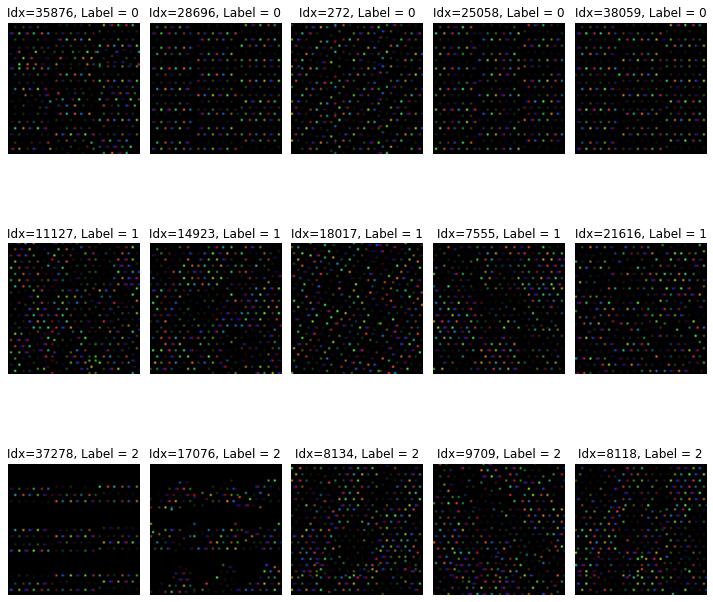

In [11]:
n = train_data.labels.shape[0]
R, C = len(np.unique(train_data.labels)), 5
fig, ax = plt.subplots(R, C, figsize = (10,10))

for label_class, plot_row in enumerate(ax):
    label_x_rows = np.where(train_data.labels == label_class)[0]
    
    for plot_cell in plot_row:
        plot_cell.grid(False)
        plot_cell.axis('off')
        idx = np.random.choice(label_x_rows)
        img = train_data.feature_vec[idx].reshape((64,64,3))
        y = train_data.labels[idx]
        plot_cell.imshow(img)
        plot_cell.set_title('Idx=%d, Label = %d' %(idx, label_class))

plt.tight_layout()

In [ ]:
from torch.utils.data import TensorDataset,DataLoader,Dataset 
from torch.optim import SGD, Adam
from torchsummary import summary
from torch_snippets import *
import torch
import torch.nn as nn

In [ ]:
def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.25),
        nn.Conv2d(ni, no, kernel_size=3, stride = 1, padding = 'same'),
        nn.LeakyReLU(negative_slope=0.2),
        nn.MaxPool2d(2)
    )

class DefectClassification(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential( 
            convBlock(3, 32),
            convBlock(32, 64),
            convBlock(64, 64),
            
            nn.Flatten(),
            nn.Linear(8*8*64, R) ) 
    
        self.loss_fn = nn.CrossEntropyLoss()
        
    def forward(self, x):
        return self.model(x)
    
    def compute_metrics(self, preds, targets):
        ce_loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return ce_loss, acc
    

def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight.data, mean=0.0, std=0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    
    
def train_batch(model, data, optimizer, criterion):
    ims, labels = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def test_batch(model, data, criterion):
    model.eval()
    ims, labels = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()

In [20]:
model = DefectClassification()
model.apply(initialize_weights)
criterion = model.compute_metrics
optimizer = Adam(model.parameters(), lr=1e-4)

In [21]:
summary(model, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1            [-1, 3, 64, 64]               0
            Conv2d-2           [-1, 32, 64, 64]             896
         LeakyReLU-3           [-1, 32, 64, 64]               0
         MaxPool2d-4           [-1, 32, 32, 32]               0
           Dropout-5           [-1, 32, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          18,496
         LeakyReLU-7           [-1, 64, 32, 32]               0
         MaxPool2d-8           [-1, 64, 16, 16]               0
           Dropout-9           [-1, 64, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          36,928
        LeakyReLU-11           [-1, 64, 16, 16]               0
        MaxPool2d-12             [-1, 64, 8, 8]               0
          Flatten-13                 [-1, 4096]               0
           Linear-14                   

In [22]:
file_2H_1T = 'test_2H_1T.txt'
#2H and 1T data set
Natoms,ngrids,position,property,_,tensor_tot= readfile(file_2H_1T)
print(tensor_tot.shape)
print("Total number of atoms: ", Natoms)

ngrids:  64 Natoms:  8400
total lines 1621200
(8400, 3, 64, 64)
Total number of atoms:  8400


In [23]:
print(list(property).count(0), list(property).count(1), list(property).count(2))

1640 6548 212


In [25]:
features={'data':tensor_tot}

with open('test_XX.p', 'wb') as infile:
    pickle.dump(features, infile, -1)


total_atoms = np.concatenate((position,property2),axis=1)
np.save("test_pos",total_atoms)
np.save("test_YY",property)
for keys in features:
    print(keys,features[keys].shape)

data (8400, 3, 64, 64)


In [26]:
test_data=readtraining_data("test_XX.p","test_YY.npy","test_pos.npy")

files to read:  test_XX.p test_YY.npy test_pos.npy
data (8400, 3, 64, 64)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
rr (8400, 64, 64, 3)
rr (8400, 4)
rr (8400,)


In [41]:
test_data.feature_vec = test_data.feature_vec.transpose((0,3,1,2)).astype('float')
print(test_data.feature_vec.shape, test_data.coordinate.shape)
print(test_data.coordinate[0])

(8400, 64, 3, 64) (8400, 4)
[3.5632  2.16205 6.608   1.     ]


In [42]:
l = test_data.labels.shape[0]
test_data.labels = test_data.labels.reshape((l))
test_data.labels.shape

(8400,)

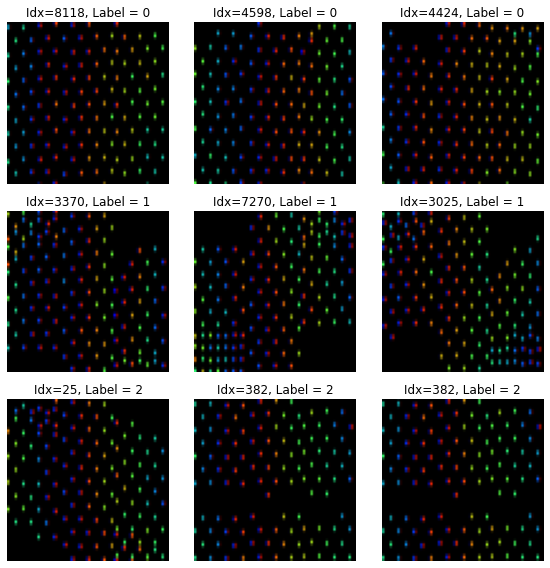

In [43]:
n = test_data.labels.shape[0]
R, C = len(np.unique(test_data.labels)), 3
fig, ax = plt.subplots(R, C, figsize = (8,8))

for label_class, plot_row in enumerate(ax):
    label_x_rows = np.where(test_data.labels == label_class)[0]
    
    for plot_cell in plot_row:
        plot_cell.grid(False)
        plot_cell.axis('off')
        idx = np.random.choice(label_x_rows)
        img = test_data.feature_vec[idx].reshape((64,64,3))
        y = test_data.labels[idx]
        plot_cell.imshow(img)
        plot_cell.set_title('Idx=%d, Label = %d' %(idx, label_class))

plt.tight_layout()

In [44]:
X_train = torch.tensor(train_data.feature_vec).float()
y_train = torch.tensor(train_data.labels, dtype = torch.int64)
print(X_train.shape, y_train.shape)

torch.Size([40426, 64, 64, 3]) torch.Size([40426])


In [31]:
X_test = torch.tensor(test_data.feature_vec).float()
y_test = torch.tensor(test_data.labels, dtype = torch.int64)
print(X_test.shape, y_test.shape)

torch.Size([8400, 3, 64, 64]) torch.Size([8400])


In [32]:
from sklearn.model_selection import train_test_split

n = X_test.shape[0]
indices = np.arange(n)

(
    X_test1,
    X_test2,
    y_test1,
    y_test2,
    indices_test1,
    indices_test2,
) = train_test_split(X_test, y_test, indices, test_size=0.02)
print(n, len(indices_test1), len(indices_test2))

8400 8232 168


In [33]:
X = torch.cat((X_train, X_test2), axis = 0)
y = torch.cat((y_train, y_test2), axis = 0)
print(X.shape, y.shape)

torch.Size([40594, 3, 64, 64]) torch.Size([40594])


In [34]:
trn_dl = DataLoader(TensorDataset(X, y), 64, shuffle=True)
test_dl = DataLoader(TensorDataset(X_test1, y_test1), 64, shuffle=True)

EPOCH: 1.000	trn_loss: 0.316	trn_acc: 0.888	test_loss: 0.333	test_acc: 0.904	(189.70s - 3604.37s remaining)
EPOCH: 2.000	trn_loss: 0.098	trn_acc: 0.965	test_loss: 0.435	test_acc: 0.817	(370.40s - 3333.57s remaining)
EPOCH: 3.000	trn_loss: 0.084	trn_acc: 0.970	test_loss: 0.196	test_acc: 0.935	(552.43s - 3130.45s remaining)
EPOCH: 4.000	trn_loss: 0.073	trn_acc: 0.975	test_loss: 0.213	test_acc: 0.930	(741.09s - 2964.38s remaining)
EPOCH: 5.000	trn_loss: 0.066	trn_acc: 0.978	test_loss: 0.245	test_acc: 0.929	(920.53s - 2761.60s remaining)
EPOCH: 6.000	trn_loss: 0.059	trn_acc: 0.980	test_loss: 0.246	test_acc: 0.933	(1101.04s - 2569.08s remaining)
EPOCH: 7.000	trn_loss: 0.055	trn_acc: 0.982	test_loss: 0.153	test_acc: 0.952	(1277.39s - 2372.29s remaining)
EPOCH: 8.000	trn_loss: 0.052	trn_acc: 0.983	test_loss: 0.137	test_acc: 0.954	(1463.10s - 2194.65s remaining)
EPOCH: 9.000	trn_loss: 0.049	trn_acc: 0.984	test_loss: 0.198	test_acc: 0.942	(1643.68s - 2008.94s remaining)
EPOCH: 10.000	trn_loss: 

100%|█████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 224.78it/s]


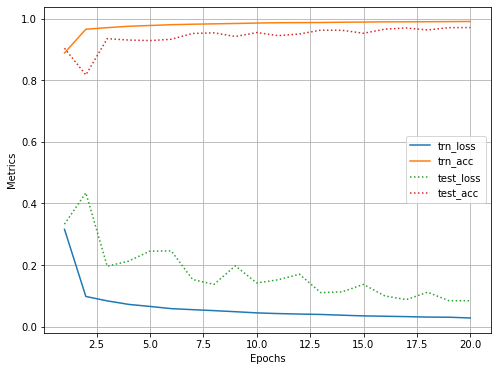

2022-04-20 09:46:22.950 | INFO     | __main__:<module>:19 - Dumped object of size ≈716 KB @ "no-aug-no-bn.log" in 6.57e-01 seconds


In [35]:
n_epochs = 20
log = Report(n_epochs)

for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')
    
    
    N = len(test_dl)
    for bx, data in enumerate(test_dl):
        loss, acc = test_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, test_loss=loss, test_acc=acc, end='\r')
    
    log.report_avgs(ex+1)

log.plot_epochs()
dumpdill(log, 'no-aug-no-bn.log')

In [100]:
natoms = test_data.feature_vec.shape[0]
natoms
x = torch.tensor(test_data.feature_vec[0][None]).float()
x.shape

torch.Size([1, 3, 64, 64])

In [101]:
test_data.coordinate.shape

(8400, 4)

In [102]:
# Generate labels from trained model and write them in a file
fileName = 'Mo_labelled_from_CNN.xyz'
fh = open(fileName, 'w')
natoms = test_data.coordinate.shape[0]
fh.write('%d\n\n' %natoms)

for i in range(natoms):
    x = torch.tensor(test_data.feature_vec[i][None]).float()
    pred = torch.max(model(x), 1)[1]
    true = test_data.labels[i]
    x, y, z, aty = test_data.coordinate[i]
    fh.write('%d %12.6f %12.6f %12.6f %d %d\n' %(aty, x, y, z, pred, true))
    #print(pred, true)

fh.close()